In [ ]:
!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/conda-forge/miniforge/releases/download/23.1.0-1/Mambaforge-23.1.0-1-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:23
🔁 Restarting kernel...


In pip, the `-q` or `--quiet` option means to run the installation command without any output, except for error messages. This is useful when you want to suppress the installation details and only view the final output.

In [ ]:
!conda --version
!which conda

conda 23.1.0
/usr/local/bin/conda


In [ ]:
!conda install -c conda-forge nest-simulator >/dev/null

In the above chunk, `>/dev/null` redirects the standard output of a command to `/dev/null`, which is a special file in Unix-like systems that discards all the data written to it. Then, there is no output, like using `-q` in "pip install" (but using `-q` or `--quiet` in "conda install" still leads to (part of) output -- a little confusing). 

If we also use `2>&1`, which redirects the standard error of the command to the same location as the standard output, then together, `>/dev/null 2>&1` redirects both standard output and standard error to `/dev/null`, which effectively suppresses all output from the command. 

So, `>/dev/null` only redirects the standard output of the command to `/dev/null`, leaving the standard error untouched. Any error messages generated by the command will still be displayed on the screen. We use `>/dev/null` here.

There is another flag `-y`, which is a common command-line option used in package managers like apt-get and yum. It is used to automatically answer "yes" to any prompts that may come up during installation or upgrading of packages, avoiding the need for user input. But it is not needed here, becuase no questions in the installation.

In [ ]:
# Loading the necessary modules:
import numpy as np
import matplotlib.pyplot as plt
import nest
import time
import json

## Mesoscopic model function (8 pops)

### function

In [ ]:
def mesoscopic(pops, pops_prop, connect_mat, mu, tau_m, V_th, 
               J_theta, tau_theta, pconn, adapt=True, seed=1):
    # simulation time interval and record time interval
    dt = 0.5
    dt_rec = 1.

    # simulation time
    t_end = 20000.

    # populations and their neuron numbers
    N = pops
    M = len(N) # numbers of populations

    # neuronal parameters
    t_ref = 2. * np.ones(M)  # absolute refractory period
    V_reset = 0. * np.ones(M)    # Reset potential

    # exponential link function for the conditional intensity (also called hazard rate, escape rate or conditional rate)
    c = 10. * np.ones(M)     # base rate of exponential link function
    Delta_u = 5. * np.ones(M)   # softness of exponential link function

    # connectivity
    # pconn = pconn_coeff * np.ones((M, M)) # probability of connections
    delay = 1.5 * np.ones((M, M)) # every two populations have a delay constant
    J_syn = connect_mat # synaptic weights

    # step current input
    step = [[0., 0.] for i in range(M)]  # jump size of mu in mV
    tstep = np.array([[60., 90.] for i in range(M)])  # times of jumps
    step[2] = [19., 0.]
    step[3] = [11.964, 0.]
    step[6] = [9.896, 0.]
    step[7] = [3.788, 0.]

    # synaptic time constants of excitatory and inhibitory connections, tau_s in the paper
    # for calculating post-synaptic currents caused by each spike of presynaptic neurons
    tau_ex = 0.5  # in ms,
    tau_in = 0.5  # in ms

    start_time = time.time()

    nest.set_verbosity("M_WARNING")
    nest.ResetKernel()
    nest.resolution = dt
    nest.print_time = True
    nest.local_num_threads = 1

    t0 = nest.biological_time

    nest_pops = nest.Create('gif_pop_psc_exp', M)

    C_m = 250.  # irrelevant value for membrane capacity, cancels out in simulation
    g_L = C_m / tau_m

    if adapt:
        q_sfa_array = J_theta / tau_theta # [J_theta]= mV*ms -> [q_sfa]=mV
        print("Adpat is True.")
    else:
        q_sfa_array = np.zeros_like(J_theta / tau_theta)
        print("Adpat is False.")

    params = [{
        'C_m': C_m,
        'I_e': mu[i] * g_L[i],
        'lambda_0': c[i],  # in Hz!
        'Delta_V': Delta_u[i],
        'tau_m': tau_m[i],
        'tau_sfa': tau_theta[i],
        'q_sfa': q_sfa_array[i],  
        'V_T_star': V_th[i],
        'V_reset': V_reset[i],
        'len_kernel': -1,  # -1 triggers automatic history size
        'N': N[i],
        't_ref': t_ref[i],
        'tau_syn_ex': max([tau_ex, dt]),
        'tau_syn_in': max([tau_in, dt]),
        'E_L': 0.
    } for i in range(M)]
    nest_pops.set(params)

    # connect the populations
    g_syn = np.ones_like(J_syn)  # synaptic conductance
    for i, prop in enumerate(pops_prop):
        if prop == 1:
            g_syn[:, i] = C_m / tau_ex
        else:
            g_syn[:, i] = C_m / tau_in
    for i in range(M):
        for j in range(M):
            nest.Connect(nest_pops[j], nest_pops[i],
                        syn_spec={'weight': J_syn[i, j] * g_syn[i, j] * pconn[i, j],
                                  'delay': delay[i, j]})

    # monitor the output using a multimeter, this only records with dt_rec!
    nest_mm = nest.Create('multimeter')
    nest_mm.set(record_from=['n_events', 'mean'], interval=dt_rec)
    nest.Connect(nest_mm, nest_pops)

    # monitor the output using a spike recorder
    nest_sr = []
    for i in range(M):
        nest_sr.append(nest.Create('spike_recorder'))
        nest_sr[i].time_in_steps = True
        nest.Connect(nest_pops[i], nest_sr[i], syn_spec={'weight': 1., 'delay': dt})

    # set initial value (at t0+dt) of step current generator to zero
    tstep = np.hstack((dt * np.ones((M, 1)), tstep))
    step = np.hstack((np.zeros((M, 1)), step))

    # create the step current devices
    nest_stepcurrent = nest.Create('step_current_generator', M)
    # set the parameters for the step currents
    for i in range(M):
        nest_stepcurrent[i].set(amplitude_times=tstep[i] + t0,
                                amplitude_values=step[i] * g_L[i],
                                origin=t0,
                                stop=t_end)
        pop_ = nest_pops[i]
        nest.Connect(nest_stepcurrent[i], pop_, syn_spec={'weight': 1., 'delay': dt})

    # begin simulation for output
    nest.rng_seed = seed

    t = np.arange(0., t_end, dt_rec)
    A_N = np.ones((t.size, M)) * np.nan
    Abar = np.ones_like(A_N) * np.nan

    # simulate 1 step longer to make sure all t are simulated
    nest.Simulate(t_end + dt)
    data_mm = nest_mm.events
    for i, nest_i in enumerate(nest_pops):
        a_i = data_mm['mean'][data_mm['senders'] == nest_i.global_id]
        a = a_i / N[i] / dt
        min_len = np.min([len(a), len(Abar)])
        Abar[:min_len, i] = a[:min_len]

        data_sr = nest_sr[i].get('events', 'times')
        data_sr = data_sr * dt - t0
        bins = np.concatenate((t, np.array([t[-1] + dt_rec])))
        A = np.histogram(data_sr, bins=bins)[0] / float(N[i]) / dt_rec
        A_N[:, i] = A

    end_time = time.time()
    elapsed_time = end_time - start_time

    return A_N, Abar, elapsed_time, t

### generate random data

In [ ]:
import os

folder_name = "pop8_data_with_adapt"
if not os.path.exists(folder_name):
    os.makedirs(folder_name)

for setting in range(1, 2):
    print(f"current setting is {setting}")

    pops = np.array([20683, 5834, 21915, 5479, 4850, 1065, 14395, 2948])
    pops_prop = np.random.choice([1, -1], size=len(pops)) # 1: excitatory, -1: inhibitory

    pconn = np.random.randint(0, 2, (len(pops), len(pops)))
    np.fill_diagonal(pconn, 1)

    J = np.random.uniform(0.06, 0.3)  # excitatory synaptic weight in mV, w^{αβ} in the paper
    g = np.random.uniform(3, 5)   # inhibition-to-excitation ratio, -g*J is the weight for inhibitory signals
    J_syn = np.outer(np.ones_like(pops_prop), np.where(pops_prop == -1, -g*J, J))
    J_syn = J_syn * pconn * np.random.uniform(0.5, 1.5, (len(pops), len(pops)))

    pconn_coeff = np.array([
        [0.1009, 0.1689, 0.0437, 0.0818, 0.0323, 0, 0.0076, 0],
        [0.1346, 0.1371, 0.0316, 0.0515, 0.0755, 0, 0.0042, 0],
        [0.0077, 0.0059, 0.0497, 0.135, 0.0067, 0.0003, 0.0453, 0],
        [0.0691, 0.0029, 0.0794, 0.1597, 0.0033, 0, 0.1057, 0],
        [0.1004, 0.0622, 0.0505, 0.0057, 0.0831, 0.3726, 0.0204, 0],
        [0.0548, 0.0269, 0.0257, 0.0022, 0.06, 0.3158, 0.0086, 0],
        [0.0156, 0.0066, 0.0211, 0.0166, 0.0572, 0.0197, 0.0396, 0.2252],
        [0.0364, 0.001, 0.0034, 0.0005, 0.0277, 0.008, 0.0658, 0.1443]
    ])
    pconn = pconn * pconn_coeff

    mu = np.random.uniform(20, 60, len(pops)) # V_rest + I_external * R
    tau_m = np.random.uniform(10, 40, len(pops))  # membrane time constant
    V_th = np.random.uniform(10, 30, len(pops))  # baseline threshold (non-accumulating part)

    tau_sfa_exc = [np.random.uniform(0, 1500)]  # threshold adaptation time constants of excitatory neurons
    tau_sfa_inh = [np.random.uniform(0, 1500)]  # threshold adaptation time constants of inhibitory neurons
    J_sfa_exc = [np.random.uniform(0, 1500)]   # adaptation strength: size of feedback kernel theta (= area under exponential) in mV*ms
    J_sfa_inh = [np.random.uniform(0, 1500)]   # in mV*ms
    tau_theta = np.array([tau_sfa_exc if prop == 1 else tau_sfa_inh for prop in pops_prop])
    J_theta = np.array([J_sfa_exc if prop == 1 else J_sfa_inh for prop in pops_prop])

    J_syn_list = J_syn.tolist()
    mu_list = mu.tolist()
    tau_m_list = tau_m.tolist()
    V_th_list = V_th.tolist()
    J_theta_list = J_theta.tolist()
    tau_theta_list = tau_theta.tolist()

    for seed_num in range(1, 3):
        A_N, Abar, elapsed_time, t = mesoscopic(pops=pops, 
                              pops_prop=pops_prop, 
                              connect_mat=J_syn, 
                              mu=mu, 
                              tau_m=tau_m, 
                              V_th=V_th, 
                              J_theta=J_theta, 
                              tau_theta=tau_theta,
                              pconn=pconn,
                              adapt=True,
                              seed=seed_num)
        A_N_list = A_N.tolist()
        Abar_list = Abar.tolist()
        t_list = t.tolist()
        data_dict = {"setting": setting, 
                "seed_num": seed_num, 
                "J_syn": J_syn_list, 
                "mu": mu_list, 
                "tau_m": tau_m_list, 
                "V_th": V_th_list, 
                "J_theta": J_theta_list, 
                "tau_theta": tau_theta_list,
                "A_N": A_N_list,
                "Abar": Abar_list,
                "t": t_list,
                "elapsed_time": elapsed_time
                }
        json_str = json.dumps(data_dict)
        filename = f"{folder_name}/data_{setting}-{seed_num}.json"
        with open(filename, 'w') as json_file:
            json_file.write(json_str)


current setting is 1
Adpat is True.
Adpat is True.


### read data and plot

In [ ]:
filename = "./pop8_data_with_adapt/data_1-1.json"

# Read the JSON string from the file
with open(filename, 'r') as json_file:
    json_str = json_file.read()

# Convert the JSON string into a dictionary
data_dict = json.loads(json_str)

# Convert the nested lists back into numpy arrays
J_syn = np.array(data_dict["J_syn"])
mu = np.array(data_dict["mu"])
tau_m = np.array(data_dict["tau_m"])
V_th = np.array(data_dict["V_th"])
J_theta = np.array(data_dict["J_theta"])
tau_theta = np.array(data_dict["tau_theta"])
A_N = np.array(data_dict["A_N"])
Abar = np.array(data_dict["Abar"])
t = np.array(data_dict["t"])

elapsed_time = data_dict["elapsed_time"]

print(data_dict.keys())

print(f"J_syn shape: {J_syn.shape}")
print(f"mu shape: {mu.shape}")
print(f"tau_m shape: {tau_m.shape}")
print(f"V_th shape: {V_th.shape}")
print(f"J_theta shape: {J_theta.shape}")
print(f"tau_theta shape: {tau_theta.shape}")
print(f"A_N shape: {A_N.shape}")



plt.figure()
plt.plot(t[:120], A_N[:120,0] * 1000)  # plot population activities (in Hz)
plt.ylabel(r'$A_N$ [Hz]')
plt.xlabel('time [ms]')
plt.title('Population activities (mesoscopic sim.)')

from scipy.ndimage import gaussian_filter1d
plt.figure()
for popi in [2]: #range(len(pops)):
    plt.plot(t[:20000], gaussian_filter1d(Abar[:20000,popi],10) * 1000)  # plot instantaneous population rates (in Hz)
plt.ylabel(r'$\bar A$ [Hz]')
plt.xlabel('time [ms]')
plt.title('Population activities (mesoscopic sim.)')

## Mesoscopic model function

### function

In [ ]:
def mesoscopic(pops, pops_prop, connect_mat, mu, tau_m, V_th, 
               J_theta, tau_theta, pconn, adapt=True, seed=1):
    # simulation time interval and record time interval
    dt = 0.5
    dt_rec = 1.

    # simulation time
    t_end = 60000.

    # populations and their neuron numbers
    N = pops
    M = len(N) # numbers of populations

    # neuronal parameters
    t_ref = 4. * np.ones(M)  # absolute refractory period
    V_reset = 0. * np.ones(M)    # Reset potential

    # exponential link function for the conditional intensity (also called hazard rate, escape rate or conditional rate)
    c = 10. * np.ones(M)     # base rate of exponential link function
    Delta_u = 2.5 * np.ones(M)   # softness of exponential link function

    # connectivity
    # pconn = pconn_coeff * np.ones((M, M)) # probability of connections
    delay = 1. * np.ones((M, M)) # every two populations have a delay constant
    J_syn = connect_mat # synaptic weights

    # step current input
    step = [[20.] for i in range(M)]  # jump size of mu in mV
    tstep = np.array([[30000.] for i in range(M)])  # times of jumps

    # synaptic time constants of excitatory and inhibitory connections, tau_s in the paper
    # for calculating post-synaptic currents caused by each spike of presynaptic neurons
    tau_ex = 3.  # in ms,
    tau_in = 6.  # in ms

    start_time = time.time()

    nest.set_verbosity("M_WARNING")
    nest.ResetKernel()
    nest.resolution = dt
    nest.print_time = True
    nest.local_num_threads = 1

    t0 = nest.biological_time

    nest_pops = nest.Create('gif_pop_psc_exp', M)

    C_m = 250.  # irrelevant value for membrane capacity, cancels out in simulation
    g_L = C_m / tau_m

    if adapt:
        q_sfa_array = J_theta / tau_theta # [J_theta]= mV*ms -> [q_sfa]=mV
        print("Adpat is True.")
    else:
        q_sfa_array = np.zeros_like(J_theta / tau_theta)
        print("Adpat is False.")

    params = [{
        'C_m': C_m,
        'I_e': mu[i] * g_L[i],
        'lambda_0': c[i],  # in Hz!
        'Delta_V': Delta_u[i],
        'tau_m': tau_m[i],
        'tau_sfa': tau_theta[i],
        'q_sfa': q_sfa_array[i],  
        'V_T_star': V_th[i],
        'V_reset': V_reset[i],
        'len_kernel': -1,  # -1 triggers automatic history size
        'N': N[i],
        't_ref': t_ref[i],
        'tau_syn_ex': max([tau_ex, dt]),
        'tau_syn_in': max([tau_in, dt]),
        'E_L': 0.
    } for i in range(M)]
    nest_pops.set(params)

    # connect the populations
    g_syn = np.ones_like(J_syn)  # synaptic conductance
    for i, prop in enumerate(pops_prop):
        if prop == 1:
            g_syn[:, i] = C_m / tau_ex
        else:
            g_syn[:, i] = C_m / tau_in
    for i in range(M):
        for j in range(M):
            nest.Connect(nest_pops[j], nest_pops[i],
                        syn_spec={'weight': J_syn[i, j] * g_syn[i, j] * pconn[i, j],
                                  'delay': delay[i, j]})

    # monitor the output using a multimeter, this only records with dt_rec!
    nest_mm = nest.Create('multimeter')
    nest_mm.set(record_from=['n_events', 'mean'], interval=dt_rec)
    nest.Connect(nest_mm, nest_pops)

    # monitor the output using a spike recorder
    nest_sr = []
    for i in range(M):
        nest_sr.append(nest.Create('spike_recorder'))
        nest_sr[i].time_in_steps = True
        nest.Connect(nest_pops[i], nest_sr[i], syn_spec={'weight': 1., 'delay': dt})

    # set initial value (at t0+dt) of step current generator to zero
    tstep = np.hstack((dt * np.ones((M, 1)), tstep))
    step = np.hstack((np.zeros((M, 1)), step))

    # create the step current devices
    nest_stepcurrent = nest.Create('step_current_generator', M)
    # set the parameters for the step currents
    for i in range(M):
        nest_stepcurrent[i].set(amplitude_times=tstep[i] + t0,
                                amplitude_values=step[i] * g_L[i],
                                origin=t0,
                                stop=t_end)
        pop_ = nest_pops[i]
        nest.Connect(nest_stepcurrent[i], pop_, syn_spec={'weight': 1., 'delay': dt})

    # begin simulation for output
    nest.rng_seed = seed

    t = np.arange(0., t_end, dt_rec)
    A_N = np.ones((t.size, M)) * np.nan
    Abar = np.ones_like(A_N) * np.nan

    # simulate 1 step longer to make sure all t are simulated
    nest.Simulate(t_end + dt)
    data_mm = nest_mm.events
    for i, nest_i in enumerate(nest_pops):
        a_i = data_mm['mean'][data_mm['senders'] == nest_i.global_id]
        a = a_i / N[i] / dt
        min_len = np.min([len(a), len(Abar)])
        Abar[:min_len, i] = a[:min_len]

        data_sr = nest_sr[i].get('events', 'times')
        data_sr = data_sr * dt - t0
        bins = np.concatenate((t, np.array([t[-1] + dt_rec])))
        A = np.histogram(data_sr, bins=bins)[0] / float(N[i]) / dt_rec
        A_N[:, i] = A

    end_time = time.time()
    elapsed_time = end_time - start_time

    return A_N, Abar, elapsed_time, t

### generate random data

In [ ]:
import os

folder_name = "pop3_data_with_adapt"
if not os.path.exists(folder_name):
    os.makedirs(folder_name)

for setting in range(1, 3):
    print(f"current setting is {setting}")

    pops = np.array([400, 200, 400])
    pops_prop = np.random.choice([1, -1], size=len(pops)) # 1: excitatory, -1: inhibitory

    pconn = np.random.randint(0, 2, (len(pops), len(pops)))
    np.fill_diagonal(pconn, 1)

    J = np.random.uniform(0.06, 0.3)  # excitatory synaptic weight in mV, w^{αβ} in the paper
    g = np.random.uniform(3, 6)   # inhibition-to-excitation ratio, -g*J is the weight for inhibitory signals
    J_syn = np.outer(np.ones_like(pops_prop), np.where(pops_prop == -1, -g*J, J))
    J_syn = J_syn * pconn * np.random.uniform(0.5, 1.5, (len(pops), len(pops)))

    pconn_coeff = 0.6
    pconn = pconn * pconn_coeff

    mu = np.random.uniform(20, 60, len(pops)) # V_rest + I_external * R
    tau_m = np.random.uniform(10, 40, len(pops))  # membrane time constant
    V_th = np.random.uniform(10, 30, len(pops))  # baseline threshold (non-accumulating part)

    tau_sfa_exc = [np.random.uniform(80, 1500)]  # threshold adaptation time constants of excitatory neurons
    tau_sfa_inh = [np.random.uniform(80, 1500)]  # threshold adaptation time constants of inhibitory neurons
    J_sfa_exc = [np.random.uniform(80, 1500)]   # adaptation strength: size of feedback kernel theta (= area under exponential) in mV*ms
    J_sfa_inh = [np.random.uniform(80, 1500)]   # in mV*ms
    tau_theta = np.array([tau_sfa_exc if prop == 1 else tau_sfa_inh for prop in pops_prop])
    J_theta = np.array([J_sfa_exc if prop == 1 else J_sfa_inh for prop in pops_prop])

    J_syn_list = J_syn.tolist()
    mu_list = mu.tolist()
    tau_m_list = tau_m.tolist()
    V_th_list = V_th.tolist()
    J_theta_list = J_theta.tolist()
    tau_theta_list = tau_theta.tolist()

    for seed_num in range(1, 3):
        A_N, Abar, elapsed_time, t = mesoscopic(pops=pops, 
                              pops_prop=pops_prop, 
                              connect_mat=J_syn, 
                              mu=mu, 
                              tau_m=tau_m, 
                              V_th=V_th, 
                              J_theta=J_theta, 
                              tau_theta=tau_theta,
                              pconn=pconn,
                              adapt=True,
                              seed=seed_num)
        A_N_list = A_N.tolist()
        Abar_list = Abar.tolist()
        t_list = t.tolist()
        data_dict = {"setting": setting, 
                "seed_num": seed_num, 
                "J_syn": J_syn_list, 
                "mu": mu_list, 
                "tau_m": tau_m_list, 
                "V_th": V_th_list, 
                "J_theta": J_theta_list, 
                "tau_theta": tau_theta_list,
                "A_N": A_N_list,
                "Abar": Abar_list,
                "t": t_list,
                "elapsed_time": elapsed_time
                }
        json_str = json.dumps(data_dict)
        filename = f"{folder_name}/data_{setting}-{seed_num}.json"
        with open(filename, 'w') as json_file:
            json_file.write(json_str)


current setting is 1
Adpat is True.
Adpat is True.
current setting is 2
Adpat is True.
Adpat is True.


### run function

In [ ]:
pops = np.array([400, 200, 400])
pops_prop = np.array([1, -1, 1]) # 1: excitatory, -1: inhibitory

pconn = np.array([[1, 1, 0],
          [1, 1, 1],
          [0, 1, 1]])
J = 0.096  # excitatory synaptic weight in mV
g = 0.384/0.096   # inhibition-to-excitation ratio, -g*J is the weight for inhibitory signals
J_syn = np.outer(np.ones_like(pops_prop), np.where(pops_prop == -1, -g*J, J))
J_syn = J_syn * pconn * 1. / 0.6

pconn_coeff = 0.6
pconn = pconn * pconn_coeff

mu = 36. * np.ones(len(pops)) # V_rest + I_external * R
tau_m = 20. * np.ones(len(pops))  # membrane time constant
V_th = 15. * np.ones(len(pops))  # baseline threshold (non-accumulating part)

tau_sfa_exc = [1000.]  # threshold adaptation time constants of excitatory neurons
tau_sfa_inh = [1000.]  # threshold adaptation time constants of inhibitory neurons
J_sfa_exc = [100.]   # adaptation strength: size of feedback kernel theta (= area under exponential) in mV*ms
J_sfa_inh = [100.]   # in mV*ms
tau_theta = np.array([tau_sfa_exc if prop == 1 else tau_sfa_inh for prop in pops_prop])
J_theta = np.array([J_sfa_exc if prop == 1 else J_sfa_inh for prop in pops_prop])

A_N, Abar, elapsed_time, t = mesoscopic(pops=pops, 
                      pops_prop=pops_prop, 
                      connect_mat=J_syn, 
                      mu=mu, 
                      tau_m=tau_m, 
                      V_th=V_th, 
                      J_theta=J_theta, 
                      tau_theta=tau_theta,
                      pconn=pconn,
                      adapt=True,
                      seed=1)

print(elapsed_time)

Adpat is True.
10.40022325515747


### plot figures

60000


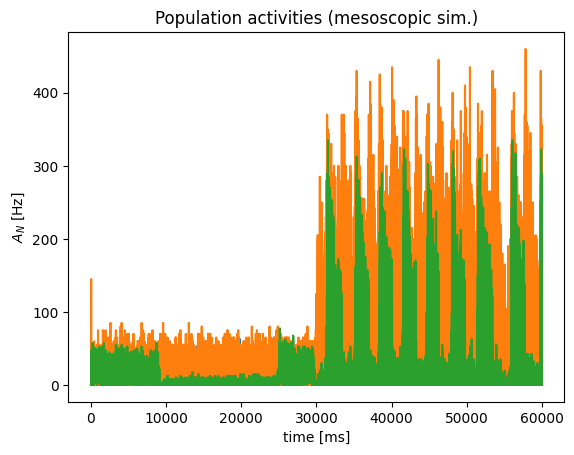

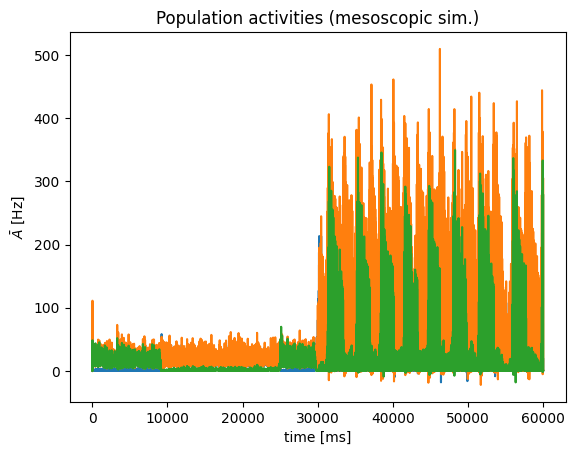

In [ ]:
plt.figure()
plt.plot(t, A_N * 1000)  # plot population activities (in Hz)
plt.ylabel(r'$A_N$ [Hz]')
plt.xlabel('time [ms]')
plt.title('Population activities (mesoscopic sim.)')
plt.figure()
plt.plot(t, Abar * 1000)  # plot instantaneous population rates (in Hz)
plt.ylabel(r'$\bar A$ [Hz]')
plt.xlabel('time [ms]')
plt.title('Population activities (mesoscopic sim.)')
print(len(A_N))

# A_N_total = 0
# seed_num = 1000
# for seed_i in range(seed_num):
#     A_N, Abar, elapsed_time, t = mesoscopic(pops=pops, 
#                           pops_prop=pops_prop, 
#                           connect_mat=J_syn, 
#                           mu=mu, 
#                           tau_m=tau_m, 
#                           V_th=V_th, 
#                           J_theta=J_theta, 
#                           tau_theta=tau_theta,
#                           pconn=pconn,
#                           adapt=True,
#                           seed=seed_i+1)
#     A_N_total = A_N_total + A_N
# A_N_avg = A_N_total / seed_num

# plt.figure()
# plt.plot(t, A_N_avg * 1000)  # plot population activities (in Hz)
# plt.ylabel(r'$A_N_avg$ [Hz]')
# plt.xlabel('time [ms]')
# plt.title('Population activities (mesoscopic sim.)')

### plot figures (filter)

60000
10.40022325515747
(60000, 3) (60000, 3)


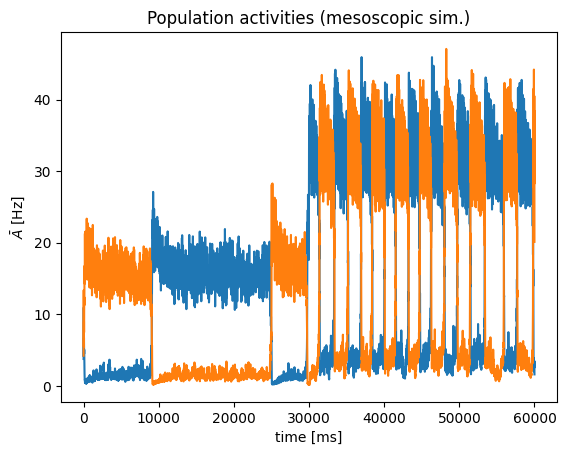

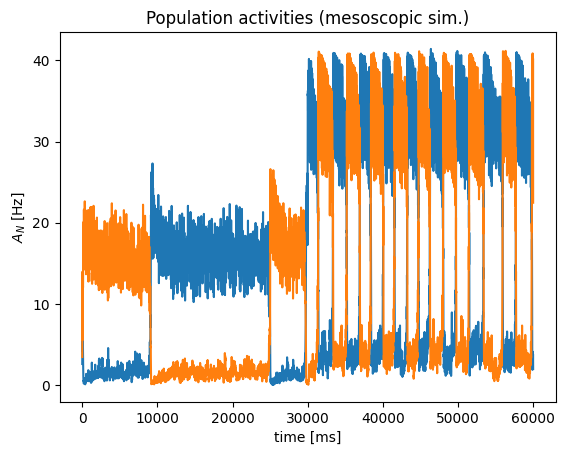

In [ ]:
from scipy.ndimage import gaussian_filter1d
plt.figure()
for popi in [0,2]: #range(len(pops)):
    plt.plot(t, gaussian_filter1d(Abar[:,popi],10) * 1000)  # plot instantaneous population rates (in Hz)
plt.ylabel(r'$\bar A$ [Hz]')
plt.xlabel('time [ms]')
plt.title('Population activities (mesoscopic sim.)')

plt.figure()
for popi in [0,2]: #range(len(pops)):
    plt.plot(t, gaussian_filter1d(A_N[:,popi],10) * 1000)  # plot instantaneous population rates (in Hz)
plt.ylabel(r'$A_N$ [Hz]')
plt.xlabel('time [ms]')
plt.title('Population activities (mesoscopic sim.)')

print(len(A_N))
print(elapsed_time)
print(Abar.shape, A_N.shape)

In [ ]:
import numpy as np
import json

# Suppose you have a numpy array and some numbers
numpy_array = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
number1 = 10
number2 = 20

# Convert the numpy array to a nested list
numpy_array_list = numpy_array.tolist()


# Store your data into a dictionary
data_dict = {"array": numpy_array_list, "number1": number1, "number2": number2}

# Convert the dictionary into a JSON string
json_str = json.dumps(data_dict)

# Write the JSON string to a file
with open('data.json', 'w') as json_file:
    json_file.write(json_str)


# Read the JSON string from the file
with open('data.json', 'r') as json_file:
    json_str = json_file.read()

# Convert the JSON string into a dictionary
data_dict = json.loads(json_str)

# Convert the nested list back into a numpy array
numpy_array = np.array(data_dict["array"])
number1 = data_dict["number1"]
number2 = data_dict["number2"]

print(data_dict)

{'array': [[1, 2, 3], [4, 5, 6], [7, 8, 9]], 'number1': 10, 'number2': 20}


## Microscopic model function

### function

In [ ]:
def microscopic(pops, pops_prop, connect_mat, mu, tau_m, V_th, 
               J_theta, tau_theta, pconn, adapt=True, seed=1):
    # simulation time interval and record time interval
    dt = 0.5
    dt_rec = 1.

    # simulation time
    t_end = 60000.

    # populations and their neuron numbers
    N = pops
    M = len(N) # numbers of populations

    # neuronal parameters
    t_ref = 4. * np.ones(M)  # absolute refractory period
    V_reset = 0. * np.ones(M)    # Reset potential

    # exponential link function for the conditional intensity (also called hazard rate, escape rate or conditional rate)
    c = 10. * np.ones(M)     # base rate of exponential link function
    Delta_u = 2.5 * np.ones(M)   # softness of exponential link function

    # connectivity
    # pconn = pconn_coeff * np.ones((M, M)) # probability of connections
    delay = 1. * np.ones((M, M)) # every two populations have a delay constant
    J_syn = connect_mat # synaptic weights

    # step current input
    step = [[20.] for i in range(M)]  # jump size of mu in mV
    tstep = np.array([[30000.] for i in range(M)])  # times of jumps

    # synaptic time constants of excitatory and inhibitory connections
    # for calculating post-synaptic currents caused by each spike of presynaptic neurons
    tau_ex = 3.  # in ms,
    tau_in = 6.  # in ms

    start_time = time.time()

    nest.set_verbosity("M_WARNING")
    nest.ResetKernel()
    nest.resolution = dt
    nest.print_time = True
    nest.local_num_threads = 1

    t0 = nest.biological_time

    nest_pops = []
    for k in range(M):
        nest_pops.append(nest.Create('gif_psc_exp', N[k]))

    C_m = 250.  # irrelevant value for membrane capacity, cancels out in simulation
    g_L = C_m / tau_m

    if adapt:
        q_sfa_array = J_theta / tau_theta # [J_theta]= mV*ms -> [q_sfa]=mV
        print("Adpat is True.")
    else:
        q_sfa_array = np.zeros_like(J_theta / tau_theta)
        print("Adpat is False.")

    # set single neuron properties

    for i in range(M):
        nest_pops[i].set(C_m=C_m,
                I_e=mu[i] * g_L[i],
                lambda_0=c[i],
                Delta_V=Delta_u[i],
                g_L=g_L[i],
                tau_sfa=tau_theta[i],
                q_sfa=q_sfa_array[i],
                V_T_star=V_th[i],
                V_reset=V_reset[i],
                t_ref=t_ref[i],
                tau_syn_ex=max([tau_ex, dt]),
                tau_syn_in=max([tau_in, dt]),
                E_L=0.,
                V_m=0.)

    # connect the populations
    g_syn = np.ones_like(J_syn)  # synaptic conductance
    for i, prop in enumerate(pops_prop):
        if prop == 1:
            g_syn[:, i] = C_m / tau_ex
        else:
            g_syn[:, i] = C_m / tau_in
        
    # connect the populations
    for i, nest_i in enumerate(nest_pops):
        for j, nest_j in enumerate(nest_pops):
            if np.allclose(pconn[i, j], 1.):
                conn_spec = {'rule': 'all_to_all'}
            else:
                conn_spec = {
                    'rule': 'fixed_indegree', 'indegree': int(pconn[i, j] * N[j])}

            nest.Connect(nest_j, nest_i,
                        conn_spec,
                        syn_spec={'weight': J_syn[i, j] * g_syn[i, j],
                                  'delay': delay[i, j]})

    # monitor the output using a multimeter and a spike recorder
    nest_sr = []
    for i, nest_i in enumerate(nest_pops):
        nest_sr.append(nest.Create('spike_recorder'))
        nest_sr[i].time_in_steps = True

        # record all spikes from population to compute population activity
        nest.Connect(nest_i, nest_sr[i], syn_spec={'weight': 1., 'delay': dt})

    Nrecord = [5 for i in range(M)]    # for each population "i" the first Nrecord[i] neurons are recorded
    nest_mm_Vm = []
    for i, nest_i in enumerate(nest_pops):
        nest_mm_Vm.append(nest.Create('multimeter'))
        nest_mm_Vm[i].set(record_from=['V_m'], interval=dt_rec)
        if Nrecord[i] != 0:
            nest.Connect(nest_mm_Vm[i], nest_i[:Nrecord[i]], syn_spec={'weight': 1., 'delay': dt})

    # set initial value (at t0+dt) of step current generator to zero
    tstep = np.hstack((dt * np.ones((M, 1)), tstep))
    step = np.hstack((np.zeros((M, 1)), step))

    # create the step current devices if they do not exist already
    nest_stepcurrent = nest.Create('step_current_generator', M)
    # set the parameters for the step currents
    for i in range(M):
        nest_stepcurrent[i].set(amplitude_times=tstep[i] + t0,
                                amplitude_values=step[i] * g_L[i],
                                origin=t0,
                                stop=t_end)
        nest_stepcurrent[i].set(amplitude_times=tstep[i] + t0,
                                amplitude_values=step[i] * g_L[i],
                                origin=t0,
                                stop=t_end)
        # optionally a stopping time may be added by: 'stop': sim_T + t0
        pop_ = nest_pops[i]
        nest.Connect(nest_stepcurrent[i], pop_, syn_spec={'weight': 1., 'delay': dt})

    # start the microscopic simulation
    nest.rng_seed = seed

    t = np.arange(0., t_end, dt_rec)
    A_N = np.ones((t.size, M)) * np.nan

    # simulate 1 step longer to make sure all t are simulated
    nest.Simulate(t_end + dt)

    for i in range(len(nest_pops)):
        data_sr = nest_sr[i].get('events', 'times') * dt - t0
        bins = np.concatenate((t, np.array([t[-1] + dt_rec])))
        A = np.histogram(data_sr, bins=bins)[0] / float(N[i]) / dt_rec
        A_N[:, i] = A * 1000  # in Hz

    end_time = time.time()
    elapsed_time = end_time - start_time

    return A_N, elapsed_time, t


### run function

In [ ]:
pops = np.array([400, 200, 400])
pops_prop = np.array([1, -1, 1]) # 1: excitatory, -1: inhibitory

pconn = np.array([[1, 1, 0],
          [1, 1, 1],
          [0, 1, 1]])
J = 0.096  # excitatory synaptic weight in mV
g = 0.384/0.096   # inhibition-to-excitation ratio, -g*J is the weight for inhibitory signals
J_syn = np.outer(np.ones_like(pops_prop), np.where(pops_prop == -1, -g*J, J))
J_syn = J_syn * pconn * 1. / 0.6

pconn_coeff = 0.6
pconn = pconn * pconn_coeff

mu = 36. * np.ones(len(pops)) # V_rest + I_external * R
tau_m = 20. * np.ones(len(pops))  # membrane time constant
V_th = 15. * np.ones(len(pops))  # baseline threshold (non-accumulating part)

tau_sfa_exc = [1000.]  # threshold adaptation time constants of excitatory neurons
tau_sfa_inh = [1000.]  # threshold adaptation time constants of inhibitory neurons
J_sfa_exc = [100.]   # adaptation strength: size of feedback kernel theta (= area under exponential) in mV*ms
J_sfa_inh = [100.]   # in mV*ms
tau_theta = np.array([tau_sfa_exc if prop == 1 else tau_sfa_inh for prop in pops_prop])
J_theta = np.array([J_sfa_exc if prop == 1 else J_sfa_inh for prop in pops_prop])


A_N, elapsed_time, t = microscopic(pops=pops, 
                    pops_prop=pops_prop, 
                    connect_mat=J_syn, 
                    mu=mu, 
                    tau_m=tau_m, 
                    V_th=V_th, 
                    J_theta=J_theta, 
                    tau_theta=tau_theta,
                    pconn=pconn,
                    adapt=True,
                    seed=1)

Adpat is True.


### plot figures

60000
65.66413450241089


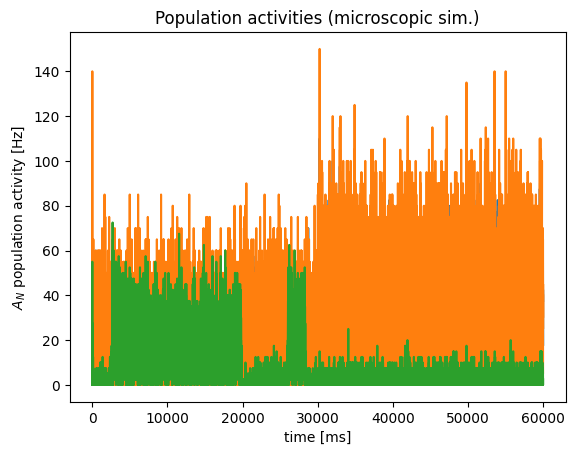

In [ ]:
plt.figure()
plt.plot(t, A_N)
plt.xlabel('time [ms]')
plt.ylabel(r'$A_N$ population activity [Hz]')
plt.title('Population activities (microscopic sim.)')
print(len(A_N))
print(elapsed_time)

# A_N_total = 0
# seed_num = 1000
# for seed_i in range(seed_num):
#     A_N, elapsed_time, t = microscopic(pops=pops, 
#                         pops_prop=pops_prop, 
#                         connect_mat=J_syn, 
#                         mu=mu, 
#                         tau_m=tau_m, 
#                         V_th=V_th, 
#                         J_theta=J_theta, 
#                         tau_theta=tau_theta,
#                         pconn=pconn,
#                         adapt=True,
#                         seed=seed_i)
#     A_N_total = A_N_total + A_N
# A_N_avg = A_N_total / seed_num

# plt.figure()
# plt.plot(t, A_N_avg * 1000)  # plot population activities (in Hz)
# plt.ylabel(r'$A_N_avg$ [Hz]')
# plt.xlabel('time [ms]')
# plt.title('Population activities (microscopic sim.)')

### plot figures (filter)

60000
52.99260115623474
(60000, 3)


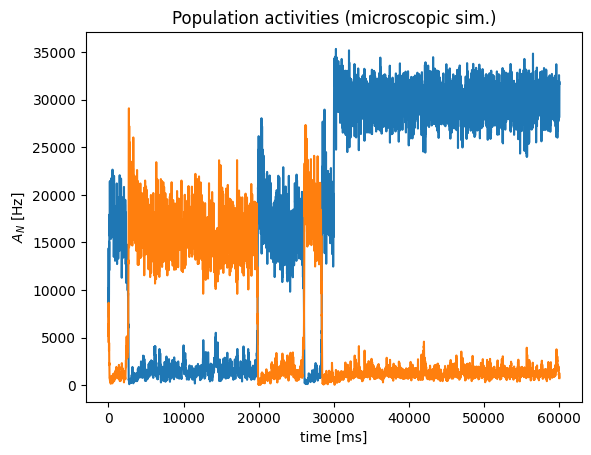

In [ ]:
from scipy.ndimage import gaussian_filter1d
plt.figure()
for popi in [0,2]: #range(len(pops)):
    plt.plot(t, gaussian_filter1d(A_N[:,popi],10) * 1000)  # plot instantaneous population rates (in Hz)
plt.ylabel(r'$A_N$ [Hz]')
plt.xlabel('time [ms]')
plt.title('Population activities (microscopic sim.)')
print(len(A_N))
print(elapsed_time)
print(A_N.shape)

## End